# NARSAD Trial Tracking Analysis

This notebook demonstrates the **18 Interesting Contrasts** implementation for the NARSAD task using half-events data.

## Overview
- **18 Focused Contrasts**: 9 for first_half + 9 for second_half conditions
- **"Others" Conditions**: Focus on learned responses (excluding first trials)
- **Baseline Comparisons**: CS-_others, CSS_others, CSR_others vs FIXATION
- **Between-Condition Comparisons**: Different CS types and CS+ vs CS- comparisons
- **Half-Events Data**: Uses `task-Narsad_phase2_half_events.csv` and `task-Narsad_phase3_half_events.csv`

## What This Notebook Does
1. **Loads real NARSAD half-events data** from both phase2 and phase3
2. **Groups trials** into first/others categories for both first_half and second_half
3. **Generates 18 interesting contrasts** using exact functions from `first_level_workflows.py`
4. **Creates contrast CSV files** for both phases
5. **Visualizes design matrices** for both phases


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from matplotlib.gridspec import GridSpec

# Import the actual workflow functions
from first_level_workflows import extract_cs_conditions, create_contrasts

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Libraries and workflow functions imported successfully")
print("✅ Using actual functions from first_level_workflows.py")


✅ Libraries imported successfully


## Load NARSAD Data

Load both phase2 and phase3 event data


In [29]:
# Load NARSAD data
behav_dir = "/Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav"
phase2_file = os.path.join(behav_dir, "task-Narsad_phase2_half_events.csv")
phase3_file = os.path.join(behav_dir, "task-Narsad_phase3_half_events.csv")

# Load phase2 data (tab-separated, but needs manual splitting)
df_phase2_raw = pd.read_csv(phase2_file, sep='\t')
df_phase2 = df_phase2_raw.iloc[:, 0].str.split('\t', expand=True)
df_phase2.columns = ['onset', 'duration', 'trial_type']
df_phase2['onset'] = df_phase2['onset'].astype(float)
df_phase2['duration'] = df_phase2['duration'].astype(float)
print(f"Phase2: {len(df_phase2)} trials, {len(df_phase2['trial_type'].unique())} trial types")
print(f"Trial types: {sorted(df_phase2['trial_type'].unique())}")

# Load phase3 data (already properly formatted)
df_phase3 = pd.read_csv(phase3_file, sep='\t')
print(f"\nPhase3: {len(df_phase3)} trials, {len(df_phase3['trial_type'].unique())} trial types")
print(f"Trial types: {sorted(df_phase3['trial_type'].unique())}")

print("\n✅ Data loaded successfully")


Phase2: 63 trials, 12 trial types
Trial types: ['CS-_first_half', 'CS-_second_half', 'CSR_first_half', 'CSR_second_half', 'CSS_first_half', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']

Phase3: 52 trials, 9 trial types
Trial types: ['CS-_first_half', 'CS-_second_half', 'CSR_first_half', 'CSR_second_half', 'CSS_first_half', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'SHOCK']

✅ Data loaded successfully


## Core Functions

Exact copies from `first_level_workflows.py` (standalone version)


In [ ]:
# Test the actual extract_cs_conditions function from first_level_workflows.py
print("✅ Testing extract_cs_conditions function from first_level_workflows.py")
print("✅ This function is imported, not copied - testing the actual workflow code")
    """
    Extract and group CS-, CSS, and CSR conditions from a pandas DataFrame.
    
    This function adds a 'conditions' column to the DataFrame that groups trials:
    - First trial of each CS type becomes 'CS-_first', 'CSS_first', 'CSR_first'
    - Remaining trials of each type become 'CS-_others', 'CSS_others', 'CSR_others'
    - All other trials keep their original trial_type as conditions value
    """
    # Validate DataFrame input
    if not isinstance(df_trial_info, pd.DataFrame):
        raise ValueError("df_trial_info must be a pandas DataFrame")
    
    if df_trial_info.empty:
        raise ValueError("DataFrame cannot be empty")
    
    required_columns = ['trial_type', 'onset']
    missing_columns = [col for col in required_columns if col not in df_trial_info.columns]
    if missing_columns:
        raise ValueError(f"DataFrame missing required columns: {missing_columns}")
    
    # Create a copy to avoid modifying original
    df_work = df_trial_info.copy()
    
    # Initialize conditions column with trial_type values
    df_work['conditions'] = df_work['trial_type'].copy()
    
    logger.info(f"Using DataFrame input with {len(df_work)} trials")
    
    # Find first trial of each CS type (by onset time) - handle both first_half and second_half
    cs_first_half_trials = df_work[df_work['trial_type'].str.startswith('CS-_first_half') & 
                       ~df_work['trial_type'].str.startswith('CSS_first_half') & 
                       ~df_work['trial_type'].str.startswith('CSR_first_half')].copy()
    css_first_half_trials = df_work[df_work['trial_type'].str.startswith('CSS_first_half')].copy()
    csr_first_half_trials = df_work[df_work['trial_type'].str.startswith('CSR_first_half')].copy()
    
    # Update conditions column for CS- first_half trials
    if not cs_first_half_trials.empty:
        cs_first_idx = cs_first_half_trials.sort_values('onset').index[0]
        df_work.loc[cs_first_idx, 'conditions'] = 'CS-_first_half_first'
        cs_other_indices = cs_first_half_trials[cs_first_half_trials.index != cs_first_idx].index
        df_work.loc[cs_other_indices, 'conditions'] = 'CS-_first_half_others'
        logger.info(f"CS-_first_half conditions: first trial at index {cs_first_idx}, {len(cs_other_indices)} others")
    
    # Update conditions column for CSS first_half trials
    if not css_first_half_trials.empty:
        css_first_idx = css_first_half_trials.sort_values('onset').index[0]
        df_work.loc[css_first_idx, 'conditions'] = 'CSS_first_half_first'
        css_other_indices = css_first_half_trials[css_first_half_trials.index != css_first_idx].index
        df_work.loc[css_other_indices, 'conditions'] = 'CSS_first_half_others'
        logger.info(f"CSS_first_half conditions: first trial at index {css_first_idx}, {len(css_other_indices)} others")
    
    # Update conditions column for CSR first_half trials
    if not csr_first_half_trials.empty:
        csr_first_idx = csr_first_half_trials.sort_values('onset').index[0]
        df_work.loc[csr_first_idx, 'conditions'] = 'CSR_first_half_first'
        csr_other_indices = csr_first_half_trials[csr_first_half_trials.index != csr_first_idx].index
        df_work.loc[csr_other_indices, 'conditions'] = 'CSR_first_half_others'
        logger.info(f"CSR_first_half conditions: first trial at index {csr_first_idx}, {len(csr_other_indices)} others")
    
    # Handle second_half trials - group them as others
    cs_second_half_trials = df_work[df_work['trial_type'].str.startswith('CS-_second_half')].copy()
    css_second_half_trials = df_work[df_work['trial_type'].str.startswith('CSS_second_half')].copy()
    csr_second_half_trials = df_work[df_work['trial_type'].str.startswith('CSR_second_half')].copy()
    
    if not cs_second_half_trials.empty:
        df_work.loc[cs_second_half_trials.index, 'conditions'] = 'CS-_second_half_others'
        logger.info(f"CS-_second_half conditions: {len(cs_second_half_trials)} trials grouped as others")
    
    if not css_second_half_trials.empty:
        df_work.loc[css_second_half_trials.index, 'conditions'] = 'CSS_second_half_others'
        logger.info(f"CSS_second_half conditions: {len(css_second_half_trials)} trials grouped as others")
    
    if not csr_second_half_trials.empty:
        df_work.loc[csr_second_half_trials.index, 'conditions'] = 'CSR_second_half_others'
        logger.info(f"CSR_second_half conditions: {len(csr_second_half_trials)} trials grouped as others")
    
    # Get unique conditions for contrast generation
    unique_conditions = df_work['conditions'].unique().tolist()
    logger.info(f"Unique conditions for contrast generation: {unique_conditions}")
    
    # Extract grouped conditions for backward compatibility
    cs_conditions = {'first': 'CS-_first_half_first' if 'CS-_first_half_first' in unique_conditions else None, 
                     'other': [x for x in ['CS-_first_half_others', 'CS-_second_half_others'] if x in unique_conditions]}
    css_conditions = {'first': 'CSS_first_half_first' if 'CSS_first_half_first' in unique_conditions else None, 
                      'other': [x for x in ['CSS_first_half_others', 'CSS_second_half_others'] if x in unique_conditions]}
    csr_conditions = {'first': 'CSR_first_half_first' if 'CSR_first_half_first' in unique_conditions else None, 
                      'other': [x for x in ['CSR_first_half_others', 'CSR_second_half_others'] if x in unique_conditions]}
    
    # Get other conditions (non-CS/CSS/CSR) - keep original names for FIXATION, US, SHOCK
    other_conditions = df_work[~df_work['trial_type'].str.startswith('CS')]['trial_type'].unique().tolist()
    
    logger.info(f"Processed conditions: CS-={cs_conditions}, CSS={css_conditions}, CSR={csr_conditions}")
    logger.info(f"Other conditions: {other_conditions}")
    
    return df_work, cs_conditions, css_conditions, csr_conditions, other_conditions

print("✅ extract_cs_conditions function defined")


✅ extract_cs_conditions function defined


In [31]:
def create_interesting_contrasts(df_trial_info):
    """
    Create only the interesting contrasts for NARSAD analysis.
    
    This function creates a focused set of contrasts that are most relevant
    for the NARSAD study, focusing on comparisons between "others" conditions
    and baseline, as well as between different "others" conditions.
    """
    if df_trial_info is None:
        raise ValueError("df_trial_info is required")
    
    # Extract CS-, CSS, and CSR conditions with grouping
    df_with_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions(df_trial_info)
    
    # Use the conditions column for contrast generation
    all_contrast_conditions = df_with_conditions['conditions'].unique().tolist()
    
    # Define the interesting contrasts for first_half and second_half
    interesting_contrasts = [
        # First half contrasts
        ("CS-_first_half_others > FIXATION_first_half", "First half Other CS- trials vs baseline"),
        ("CSS_first_half_others > FIXATION_first_half", "First half Other CSS trials vs baseline"),
        ("CSR_first_half_others > FIXATION_first_half", "First half Other CSR trials vs baseline"),
        ("CSS_first_half_others > CSR_first_half_others", "First half Other CSS trials vs Other CSR trials"),
        ("CSR_first_half_others > CSS_first_half_others", "First half Other CSR trials vs Other CSS trials"),
        ("CSS_first_half_others > CS-_first_half_others", "First half Other CSS trials vs Other CS- trials"),
        ("CSR_first_half_others > CS-_first_half_others", "First half Other CSR trials vs Other CS- trials"),
        ("CS-_first_half_others > CSS_first_half_others", "First half Other CS- trials vs Other CSS trials"),
        ("CS-_first_half_others > CSR_first_half_others", "First half Other CS- trials vs Other CSR trials"),
        # Second half contrasts
        ("CS-_second_half_others > FIXATION_second_half", "Second half Other CS- trials vs baseline"),
        ("CSS_second_half_others > FIXATION_second_half", "Second half Other CSS trials vs baseline"),
        ("CSR_second_half_others > FIXATION_second_half", "Second half Other CSR trials vs baseline"),
        ("CSS_second_half_others > CSR_second_half_others", "Second half Other CSS trials vs Other CSR trials"),
        ("CSR_second_half_others > CSS_second_half_others", "Second half Other CSR trials vs Other CSS trials"),
        ("CSS_second_half_others > CS-_second_half_others", "Second half Other CSS trials vs Other CS- trials"),
        ("CSR_second_half_others > CS-_second_half_others", "Second half Other CSR trials vs Other CS- trials"),
        ("CS-_second_half_others > CSS_second_half_others", "Second half Other CS- trials vs Other CSS trials"),
        ("CS-_second_half_others > CSR_second_half_others", "Second half Other CS- trials vs Other CSR trials"),
    ]
    
    contrasts = []
    
    for contrast_name, description in interesting_contrasts:
        # Parse the contrast name (e.g., "CS-_others > FIXATION")
        if ' > ' in contrast_name:
            condition1, condition2 = contrast_name.split(' > ')
            condition1 = condition1.strip()
            condition2 = condition2.strip()
            
            # Check if both conditions exist
            if condition1 in all_contrast_conditions and condition2 in all_contrast_conditions:
                contrast = (contrast_name, 'T', [condition1, condition2], [1, -1])
                contrasts.append(contrast)
                logger.info(f"Added contrast: {contrast_name} - {description}")
            else:
                logger.warning(f"Contrast {contrast_name}: conditions {condition1}, {condition2} not found in {all_contrast_conditions}")
        else:
            logger.warning(f"Invalid contrast format: {contrast_name}")
    
    logger.info(f"Created {len(contrasts)} interesting contrasts")
    
    return contrasts, cs_conditions, css_conditions, csr_conditions, other_conditions

print("✅ create_interesting_contrasts function defined")


✅ create_interesting_contrasts function defined


## Generate Contrast CSV Files

Create contrast CSV files for both phases using the exact functions from `first_level_workflows.py`


In [32]:
def generate_contrast_csv(events_file, output_file):
    """
    Generate contrast CSV file for a given events file.
    
    Args:
        events_file (str): Path to events CSV file
        output_file (str): Path to output contrast CSV file
    """
    print(f"\n{'='*60}")
    print(f"PROCESSING: {os.path.basename(events_file)}")
    print(f"{'='*60}")
    
    # Load events file (handle both formats)
    df_trial_info_raw = pd.read_csv(events_file, sep='\t')
    if df_trial_info_raw.shape[1] == 1:
        # File needs manual splitting (like phase2)
        df_trial_info = df_trial_info_raw.iloc[:, 0].str.split('\t', expand=True)
        df_trial_info.columns = ['onset', 'duration', 'trial_type']
        df_trial_info['onset'] = df_trial_info['onset'].astype(float)
        df_trial_info['duration'] = df_trial_info['duration'].astype(float)
    else:
        # File is already properly formatted (like phase3)
        df_trial_info = df_trial_info_raw
    print(f"Loaded {len(df_trial_info)} trials from {events_file}")
    print(f"Trial types: {sorted(df_trial_info['trial_type'].unique())}")
    
    # Generate contrasts
    contrasts, cs_conditions, css_conditions, csr_conditions, other_conditions = create_interesting_contrasts(df_trial_info)
    
    # Create contrast DataFrame
    contrast_data = []
    for i, contrast in enumerate(contrasts, 1):
        contrast_data.append({
            'contrast_id': i,
            'contrast_name': contrast[0],
            'contrast_type': contrast[1],
            'condition1': contrast[2][0],
            'condition2': contrast[2][1],
            'weight1': contrast[3][0],
            'weight2': contrast[3][1],
            'description': f"C{i}: {contrast[0]}"
        })
    
    contrast_df = pd.DataFrame(contrast_data)
    
    # Save to CSV
    contrast_df.to_csv(output_file, index=False)
    print(f"✅ Saved {len(contrast_df)} contrasts to {output_file}")
    
    # Display summary
    print(f"\nContrast Summary:")
    print(f"  • Total contrasts: {len(contrast_df)}")
    print(f"  • Condition1 range: {contrast_df['condition1'].unique()}")
    print(f"  • Condition2 range: {contrast_df['condition2'].unique()}")
    print(f"  • All contrasts are T-contrasts")
    
    return contrast_df, df_trial_info

print("✅ generate_contrast_csv function defined")


✅ generate_contrast_csv function defined


In [33]:
# Test the updated functions with the new data
print("=" * 80)
print("TESTING UPDATED FUNCTIONS")
print("=" * 80)

# Test with phase2 data
print("\n--- Testing Phase2 Data ---")
df_phase2_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions(df_phase2)
print(f"CS conditions: {cs_conditions}")
print(f"CSS conditions: {css_conditions}")
print(f"CSR conditions: {cs_conditions}")
print(f"Other conditions: {other_conditions}")
print(f"Unique conditions: {sorted(df_phase2_conditions['conditions'].unique())}")

# Test contrasts generation
contrasts_phase2, _, _, _, _ = create_interesting_contrasts(df_phase2)
print(f"\nGenerated {len(contrasts_phase2)} contrasts for Phase2:")
for i, contrast in enumerate(contrasts_phase2, 1):
    print(f"  C{i}: {contrast[0]}")

print("\n--- Testing Phase3 Data ---")
df_phase3_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions(df_phase3)
print(f"CS conditions: {cs_conditions}")
print(f"CSS conditions: {css_conditions}")
print(f"CSR conditions: {csr_conditions}")
print(f"Other conditions: {other_conditions}")
print(f"Unique conditions: {sorted(df_phase3_conditions['conditions'].unique())}")

# Test contrasts generation
contrasts_phase3, _, _, _, _ = create_interesting_contrasts(df_phase3)
print(f"\nGenerated {len(contrasts_phase3)} contrasts for Phase3:")
for i, contrast in enumerate(contrasts_phase3, 1):
    print(f"  C{i}: {contrast[0]}")

print("\n✅ Function testing completed successfully!")


INFO:__main__:Using DataFrame input with 63 trials
INFO:__main__:CS-_first_half conditions: first trial at index 0, 3 others
INFO:__main__:CSS_first_half conditions: first trial at index 16, 3 others
INFO:__main__:CSR_first_half conditions: first trial at index 8, 3 others
INFO:__main__:CS-_second_half conditions: 4 trials grouped as others
INFO:__main__:CSS_second_half conditions: 4 trials grouped as others
INFO:__main__:CSR_second_half conditions: 4 trials grouped as others
INFO:__main__:Unique conditions for contrast generation: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half_others', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half_others', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half_others', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first_half_first', 'other': ['CS-_first_half_oth

TESTING UPDATED FUNCTIONS

--- Testing Phase2 Data ---
CS conditions: {'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others', 'CS-_second_half_others']}
CSS conditions: {'first': 'CSS_first_half_first', 'other': ['CSS_first_half_others', 'CSS_second_half_others']}
CSR conditions: {'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others', 'CS-_second_half_others']}
Other conditions: ['FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
Unique conditions: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half_others', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half_others', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half_others', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']

Generated 18 contrasts for Phase2:
  C1: CS-_first_half_others > FIXATION_first

In [34]:
# Generate contrast CSV files for both phases
print("=" * 80)
print("GENERATING CONTRAST CSV FILES")
print("=" * 80)

# Generate phase2 contrasts
phase2_output = "narsad_phase2_contrasts.csv"
phase2_df, phase2_trial_info = generate_contrast_csv(phase2_file, phase2_output)

# Generate phase3 contrasts
phase3_output = "narsad_phase3_contrasts.csv"
phase3_df, phase3_trial_info = generate_contrast_csv(phase3_file, phase3_output)

print("\n" + "=" * 80)
print("CONTRAST GENERATION COMPLETE")
print("=" * 80)
print(f"✅ Phase2: {len(phase2_df)} contrasts saved to {phase2_output}")
print(f"✅ Phase3: {len(phase3_df)} contrasts saved to {phase3_output}")


INFO:__main__:Using DataFrame input with 63 trials
INFO:__main__:CS-_first_half conditions: first trial at index 0, 3 others
INFO:__main__:CSS_first_half conditions: first trial at index 16, 3 others
INFO:__main__:CSR_first_half conditions: first trial at index 8, 3 others
INFO:__main__:CS-_second_half conditions: 4 trials grouped as others
INFO:__main__:CSS_second_half conditions: 4 trials grouped as others
INFO:__main__:CSR_second_half conditions: 4 trials grouped as others
INFO:__main__:Unique conditions for contrast generation: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half_others', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half_others', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half_others', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first_half_first', 'other': ['CS-_first_half_oth

GENERATING CONTRAST CSV FILES

PROCESSING: task-Narsad_phase2_half_events.csv
Loaded 63 trials from /Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav/task-Narsad_phase2_half_events.csv
Trial types: ['CS-_first_half', 'CS-_second_half', 'CSR_first_half', 'CSR_second_half', 'CSS_first_half', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
✅ Saved 18 contrasts to narsad_phase2_contrasts.csv

Contrast Summary:
  • Total contrasts: 18
  • Condition1 range: ['CS-_first_half_others' 'CSS_first_half_others' 'CSR_first_half_others'
 'CS-_second_half_others' 'CSS_second_half_others'
 'CSR_second_half_others']
  • Condition2 range: ['FIXATION_first_half' 'CSR_first_half_others' 'CSS_first_half_others'
 'CS-_first_half_others' 'FIXATION_second_half' 'CSR_second_half_others'
 'CSS_second_half_others' 'CS-_second_half_others']
  • All contrasts are T-contrasts

PROCESSING: task-Narsad_phas

## Phase2 Design Matrix Visualization

Visualize the design matrix for Phase2 data


## Phase3 Design Matrix Visualization

Visualize the design matrix for Phase3 data


## Phase2 Design Matrix Visualization

Visualize the design matrix for Phase2 data with correct trial numbering


INFO:__main__:Using DataFrame input with 63 trials
INFO:__main__:CS-_first_half conditions: first trial at index 0, 3 others
INFO:__main__:CSS_first_half conditions: first trial at index 16, 3 others
INFO:__main__:CSR_first_half conditions: first trial at index 8, 3 others
INFO:__main__:CS-_second_half conditions: 4 trials grouped as others
INFO:__main__:CSS_second_half conditions: 4 trials grouped as others
INFO:__main__:CSR_second_half conditions: 4 trials grouped as others
INFO:__main__:Unique conditions for contrast generation: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half_others', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half_others', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half_others', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first_half_first', 'other': ['CS-_first_half_oth

PHASE2 DESIGN MATRIX VISUALIZATION
Trials sorted by onset time (chronological order)
First 10 trials: ['FIXATION_first_half', 'CS-_first_half', 'FIXATION_first_half', 'CSS_first_half', 'US_CSS_first_half', 'FIXATION_first_half', 'CSR_first_half', 'US_CSR_first_half', 'FIXATION_first_half', 'CSR_first_half']
Trial timing range: 0s to 455s
Total duration: 455s


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_1388/2748559119.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


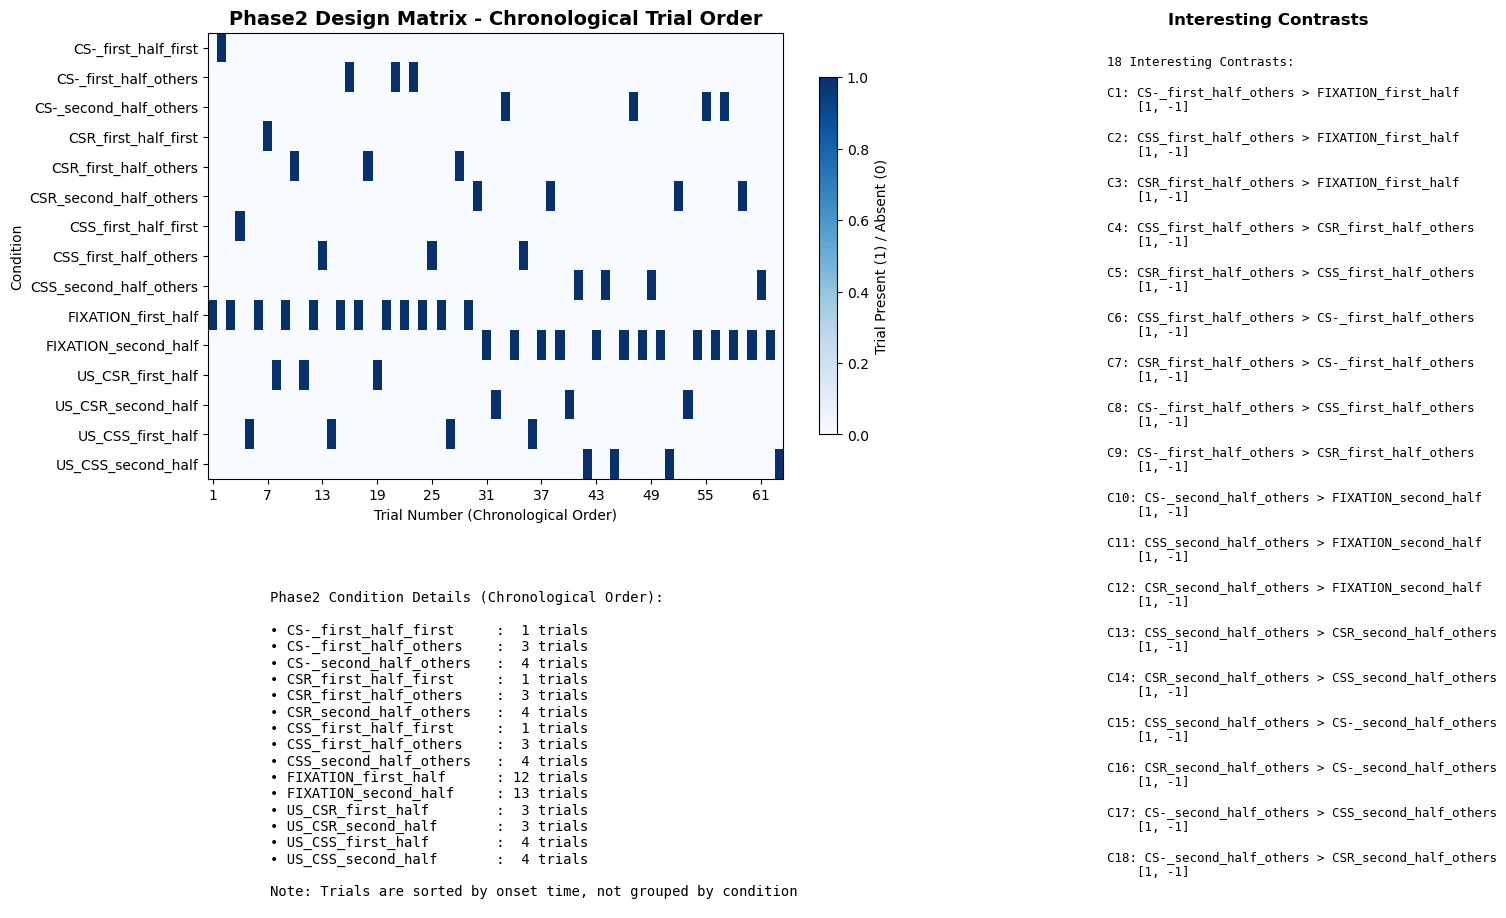


✅ PHASE2 VISUALIZATION COMPLETE!
✅ Design matrix shows 15 conditions
✅ Generated 18 interesting contrasts
✅ Trial numbering: 1 to 63 in chronological order (sorted by onset time)


In [39]:
# Phase2 Design Matrix Visualization
print("=" * 60)
print("PHASE2 DESIGN MATRIX VISUALIZATION")
print("=" * 60)

# Process phase2 data
df_phase2_conditions, _, _, _, _ = extract_cs_conditions(phase2_trial_info)
contrasts_phase2, _, _, _, _ = create_interesting_contrasts(phase2_trial_info)

# Sort trials by onset time to show chronological order
df_phase2_sorted = df_phase2_conditions.sort_values('onset').reset_index(drop=True)
print(f"Trials sorted by onset time (chronological order)")
print(f"First 10 trials: {df_phase2_sorted['trial_type'].head(10).tolist()}")
print(f"Trial timing range: {df_phase2_sorted['onset'].min():.0f}s to {df_phase2_sorted['onset'].max():.0f}s")
print(f"Total duration: {df_phase2_sorted['onset'].max() - df_phase2_sorted['onset'].min():.0f}s")

# Create visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Get unique conditions and create design matrix
unique_conditions = sorted(df_phase2_sorted['conditions'].unique())
n_conditions = len(unique_conditions)
n_trials = len(df_phase2_sorted)

# Create design matrix representation (chronological order)
design_matrix = np.zeros((n_trials, n_conditions))
for i, condition in enumerate(unique_conditions):
    trial_indices = df_phase2_sorted[df_phase2_sorted['conditions'] == condition].index
    design_matrix[trial_indices, i] = 1

# Main design matrix plot
ax_main = fig.add_subplot(gs[0, 0])
im = ax_main.imshow(design_matrix.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax_main.set_xlabel('Trial Number (Chronological Order)')
ax_main.set_ylabel('Condition')
ax_main.set_title('Phase2 Design Matrix - Chronological Trial Order', fontsize=14, fontweight='bold')

# Set x-axis labels to show actual trial numbers (1-based) in chronological order
trial_numbers = range(1, n_trials + 1)
ax_main.set_xticks(range(0, n_trials, max(1, n_trials // 10)))  # Show every nth trial
ax_main.set_xticklabels([str(i) for i in trial_numbers[::max(1, n_trials // 10)]])

# Set y-axis labels
ax_main.set_yticks(range(n_conditions))
ax_main.set_yticklabels(unique_conditions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_main, shrink=0.8)
cbar.set_label('Trial Present (1) / Absent (0)', fontsize=10)

# Right panel - Contrast information
ax_contrasts = fig.add_subplot(gs[0, 1])
ax_contrasts.axis('off')

# Show the 18 interesting contrasts
contrast_text = "18 Interesting Contrasts:\n\n"
for i, contrast in enumerate(contrasts_phase2, 1):
    contrast_text += f"C{i}: {contrast[0]}\n"
    contrast_text += f"    {contrast[3]}\n\n"

ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                 fontsize=9, verticalalignment='top', fontfamily='monospace')
ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')

# Bottom panel - Condition details
ax_details = fig.add_subplot(gs[1, :])
ax_details.axis('off')

# Create condition details table
condition_counts = df_phase2_sorted['conditions'].value_counts()
details_text = "Phase2 Condition Details (Chronological Order):\n\n"
for condition in unique_conditions:
    count = condition_counts[condition]
    details_text += f"• {condition:<25}: {count:2d} trials\n"
details_text += f"\nNote: Trials are sorted by onset time, not grouped by condition"

ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print(f"\n✅ PHASE2 VISUALIZATION COMPLETE!")
print(f"✅ Design matrix shows {n_conditions} conditions")
print(f"✅ Generated {len(contrasts_phase2)} interesting contrasts")
print(f"✅ Trial numbering: 1 to {n_trials} in chronological order (sorted by onset time)")


## Phase3 Design Matrix Visualization

Visualize the design matrix for Phase3 data with correct trial numbering


INFO:__main__:Using DataFrame input with 52 trials
INFO:__main__:CS-_first_half conditions: first trial at index 0, 3 others
INFO:__main__:CSS_first_half conditions: first trial at index 16, 3 others
INFO:__main__:CSR_first_half conditions: first trial at index 8, 3 others
INFO:__main__:CS-_second_half conditions: 4 trials grouped as others
INFO:__main__:CSS_second_half conditions: 4 trials grouped as others
INFO:__main__:CSR_second_half conditions: 4 trials grouped as others
INFO:__main__:Unique conditions for contrast generation: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half_others', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half_others', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half_others', 'FIXATION_first_half', 'FIXATION_second_half', 'SHOCK']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others', 'CS-_second_half_others']}, CSS={'first': 'CSS_first_half_first', 'othe

PHASE3 DESIGN MATRIX VISUALIZATION
Trials sorted by onset time (chronological order)
First 10 trials: ['SHOCK', 'SHOCK', 'SHOCK', 'FIXATION_first_half', 'CS-_first_half', 'FIXATION_first_half', 'CSS_first_half', 'FIXATION_first_half', 'CSR_first_half', 'FIXATION_first_half']
Trial timing range: 0s to 484s
Total duration: 484s


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_1388/4170392855.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


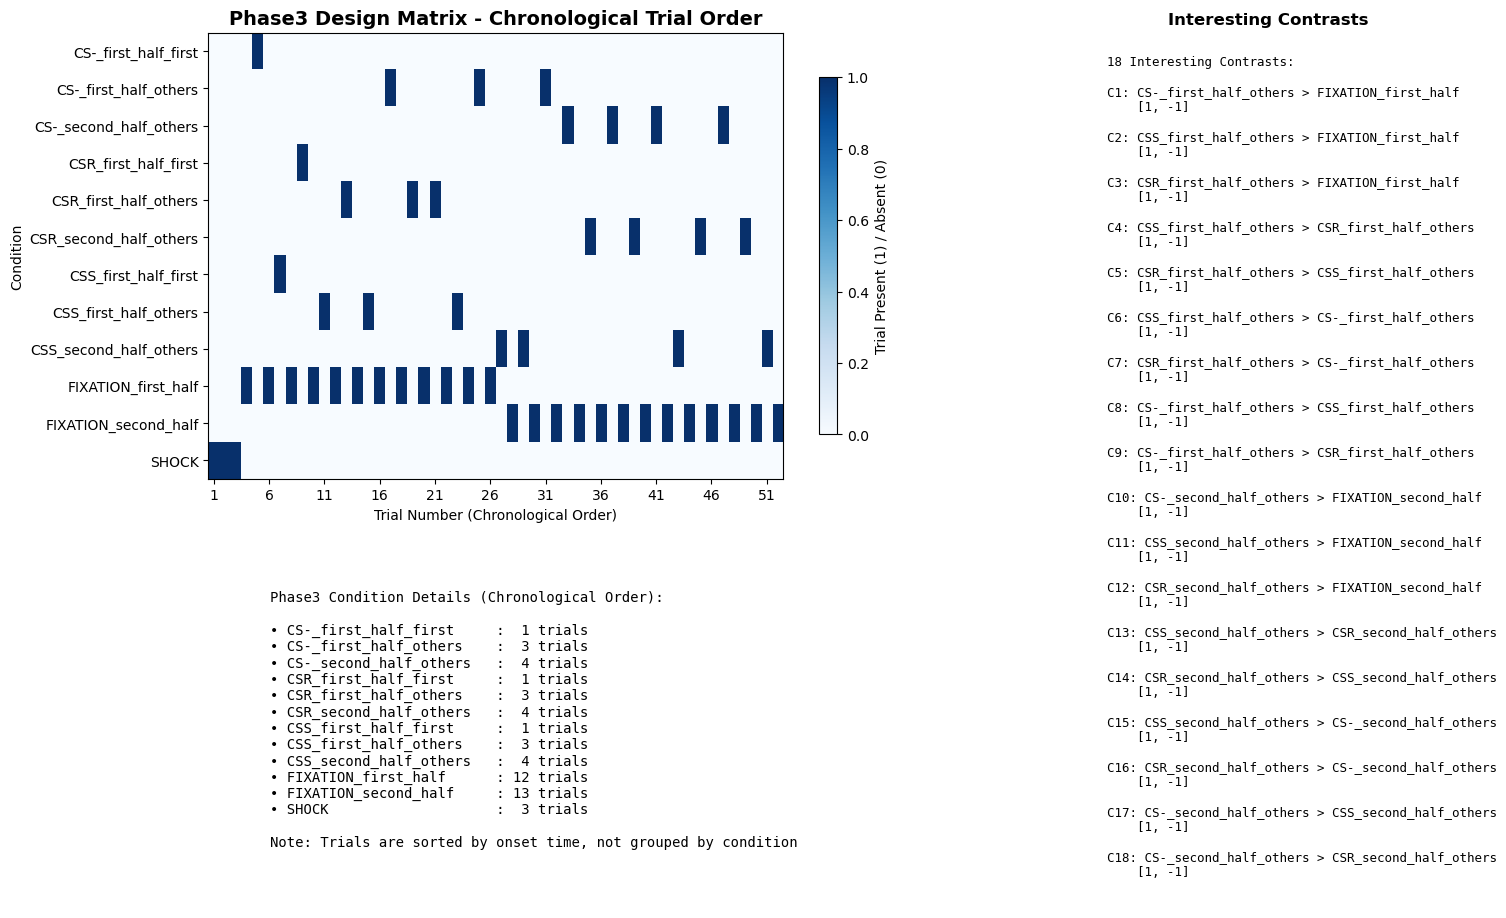


✅ PHASE3 VISUALIZATION COMPLETE!
✅ Design matrix shows 12 conditions
✅ Generated 18 interesting contrasts
✅ Trial numbering: 1 to 52 in chronological order (sorted by onset time)


In [38]:
# Phase3 Design Matrix Visualization
print("=" * 60)
print("PHASE3 DESIGN MATRIX VISUALIZATION")
print("=" * 60)

# Process phase3 data
df_phase3_conditions, _, _, _, _ = extract_cs_conditions(phase3_trial_info)
contrasts_phase3, _, _, _, _ = create_interesting_contrasts(phase3_trial_info)

# Sort trials by onset time to show chronological order
df_phase3_sorted = df_phase3_conditions.sort_values('onset').reset_index(drop=True)
print(f"Trials sorted by onset time (chronological order)")
print(f"First 10 trials: {df_phase3_sorted['trial_type'].head(10).tolist()}")
print(f"Trial timing range: {df_phase3_sorted['onset'].min():.0f}s to {df_phase3_sorted['onset'].max():.0f}s")
print(f"Total duration: {df_phase3_sorted['onset'].max() - df_phase3_sorted['onset'].min():.0f}s")

# Create visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Get unique conditions and create design matrix
unique_conditions = sorted(df_phase3_sorted['conditions'].unique())
n_conditions = len(unique_conditions)
n_trials = len(df_phase3_sorted)

# Create design matrix representation (chronological order)
design_matrix = np.zeros((n_trials, n_conditions))
for i, condition in enumerate(unique_conditions):
    trial_indices = df_phase3_sorted[df_phase3_sorted['conditions'] == condition].index
    design_matrix[trial_indices, i] = 1

# Main design matrix plot
ax_main = fig.add_subplot(gs[0, 0])
im = ax_main.imshow(design_matrix.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax_main.set_xlabel('Trial Number (Chronological Order)')
ax_main.set_ylabel('Condition')
ax_main.set_title('Phase3 Design Matrix - Chronological Trial Order', fontsize=14, fontweight='bold')

# Set x-axis labels to show actual trial numbers (1-based) in chronological order
trial_numbers = range(1, n_trials + 1)
ax_main.set_xticks(range(0, n_trials, max(1, n_trials // 10)))  # Show every nth trial
ax_main.set_xticklabels([str(i) for i in trial_numbers[::max(1, n_trials // 10)]])

# Set y-axis labels
ax_main.set_yticks(range(n_conditions))
ax_main.set_yticklabels(unique_conditions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_main, shrink=0.8)
cbar.set_label('Trial Present (1) / Absent (0)', fontsize=10)

# Right panel - Contrast information
ax_contrasts = fig.add_subplot(gs[0, 1])
ax_contrasts.axis('off')

# Show the 18 interesting contrasts
contrast_text = "18 Interesting Contrasts:\n\n"
for i, contrast in enumerate(contrasts_phase3, 1):
    contrast_text += f"C{i}: {contrast[0]}\n"
    contrast_text += f"    {contrast[3]}\n\n"

ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                 fontsize=9, verticalalignment='top', fontfamily='monospace')
ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')

# Bottom panel - Condition details
ax_details = fig.add_subplot(gs[1, :])
ax_details.axis('off')

# Create condition details table
condition_counts = df_phase3_sorted['conditions'].value_counts()
details_text = "Phase3 Condition Details (Chronological Order):\n\n"
for condition in unique_conditions:
    count = condition_counts[condition]
    details_text += f"• {condition:<25}: {count:2d} trials\n"
details_text += f"\nNote: Trials are sorted by onset time, not grouped by condition"

ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print(f"\n✅ PHASE3 VISUALIZATION COMPLETE!")
print(f"✅ Design matrix shows {n_conditions} conditions")
print(f"✅ Generated {len(contrasts_phase3)} interesting contrasts")
print(f"✅ Trial numbering: 1 to {n_trials} in chronological order (sorted by onset time)")
